# Implementing and Training a ResNet on CIFAR-10

## Overview
In this assignment, you will:
1. Implement a Convolutional Residual Network (ResNet) from scratch
2. Train your model on the CIFAR-10 dataset
3. Optimize hyperparameters to achieve the best possible accuracy

## Grading Breakdown
- Implementation (60 points): Correct implementation of ResNet blocks and model
- Performance (20 points): Test accuracy achieved
  - 80-100%: 20 points
  - 75-80%: 15 points
  - 70-75%: 10 points
  - <70%: 5 points

## Submission Requirements
Your zip file should contain:
- `HW4.ipynb` - Your completed notebook
- `results.pkl` - Results file with best run

Instructions


1. Do not modify cells marked with `DO NOT CHANGE THIS CELL`
2. Do not add any import statements beyond those provided
3. Complete all `NotImplemented` sections
4. Keep `# AUTOGRADED` tags at the beginning of code cells

**Note**: This assignment can require additional compute. We have benchmarked the training to take around 10 minutes on a single NVIDIA A6000 GPU and about 30 minutes on a MacBook CPU. If desired, GPU resources are readily available through Google Colab by uploading both HW4.ipynb and HW4_utils.py to Google Drive.

In [1]:
"""
DO NOT CHANGE THIS CELL OR ADD ANY IMPORTS IN THE NOTEBOOK
"""

# utilities
import os
from typing import Sequence
import pickle 

# for interactive plotting
try:
    from google.colab import drive
    drive.mount("/content/drive")
    # save a copy of the notebook to the drive
except ImportError:
    print("Not in Colab")

# provided code you can or should use:
from HW4_utils import zip_files, train

import torch
from torch import nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision.transforms import v2

if torch.cuda.is_available():
    Device = 'cuda'
elif torch.backends.mps.is_available():
    Device = 'mps'
else:
    Device = 'cpu'

print(f'Device is {Device}')

Not in Colab
Device is cpu



# Part 1: Model Implementation

## Understanding ResNet Architecture

ResNet (Residual Network) was introduced in the paper ["Deep Residual Learning for Image Recognition"](https://arxiv.org/pdf/1512.03385) and revolutionized deep learning by introducing skip connections (also called residual connections).


### Visual Guide:

The diagram shows:
- **Input**: Shape (B, C, H, W) - Batch, Channels, Height, Width
- **Conv1**: Strided convolution that may change spatial dimensions
- **Conv2**: Maintain dimensions after Conv1
- **Shortcut**: Identity or projection to match dimensions
- **Output**: Shape (B, C×e, H÷e, W÷e) where e is the expansion factor. 

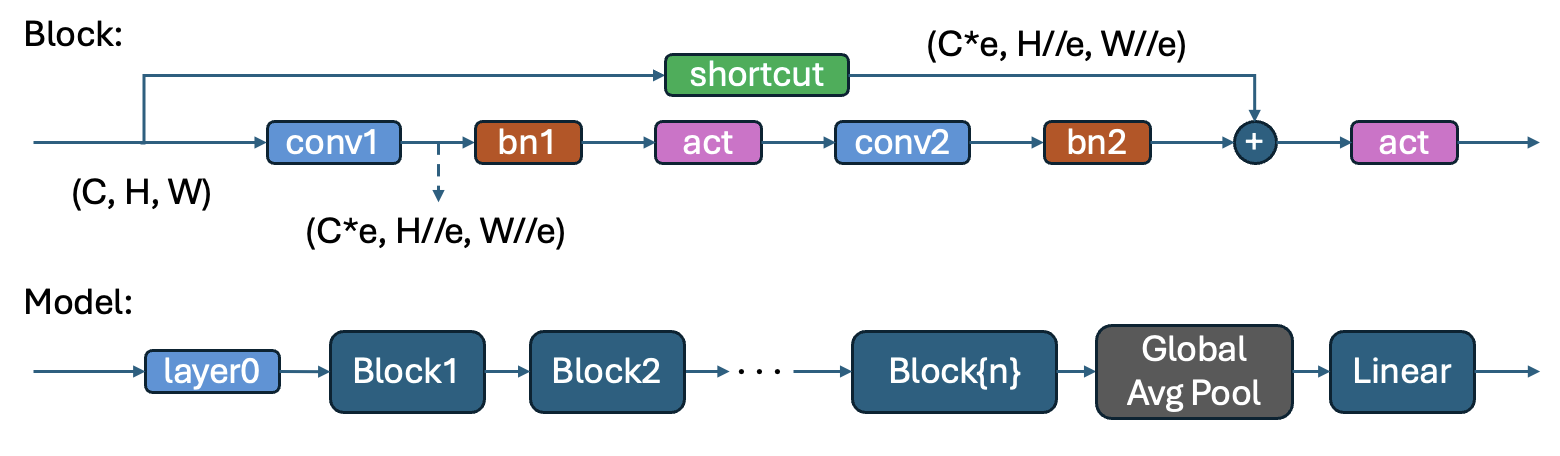

## Implementation Guidelines

### Block Class (30 Points)
Implement a residual block with the following features:

**Parameters:**
- `in_channels`: Number of input channels
- `expand`: Expansion factor (e) - multiplies channels and divides spatial dimensions
- `activation`: Name of activation function from `torch.nn.functional`
- `batchnorm`: Whether to use batch normalization
- `residual`: Whether to include skip connection

**Design Decisions:**
1. Conv1 and Conv2 use `kernel_size=3`
2. Padding: Calculate to maintain spatial dimensions when `stride=1`
3. Stride: Use `stride=expand` for first conv to downsample
4. Skip connection: 
   - If `expand=1`: Use identity (no operation)
   - If `expand>1`: Use 1×1 conv with appropriate stride + optional batchnorm

**Architecture Flow:**
```
x → Conv1(stride=e) → [BatchNorm] → Activation → 
    Conv2(stride=1) → [BatchNorm] → 
    + Shortcut(x) → Activation → Output
```
`[BatchNorm]` is evaluated only if `batchnorm=True` and `+Shortcut(x)` is only evaluated if `residual=True`

In [3]:
# AUTOGRADED

class Block(nn.Module):
    """
    A single ResNet block with optional residual connections.
    
    Args:
        in_channels: Number of input channels
        expand: Expansion factor (multiplies channels, divides spatial dims)
        activation: Name of activation function from torch.nn.functional
        batchnorm: Whether to use batch normalization
        residual: Whether to include skip connection
    """

    def __init__(
            self,
            in_channels: int,
            expand: int = 1,
            activation: str = 'relu',
            batchnorm: bool = False,
            residual: bool = False,
            ):
        super().__init__()

        # Store activation function
        self.act = F.__getattribute__(activation)
        
        # TODO: Implement the block architecture
        # Hints:
        # 1. Calculate output channels: out_channels = in_channels * expand
        # 2. First conv: stride=expand, padding=1, project to out_channels
        # 3. Second conv: stride=1, padding=1
        # 4. Add batchnorm layers if batchnorm=True
        # 5. Implement shortcut:
        #    - If expand=1 and residual=True: nn.Identity()
        #    - If expand>1 and residual=True: 1x1 conv + optional batchnorm
        #    - If residual=False: Don't create shortcut modules
        
        self.use_batchnorm = batchnorm
        self.use_residual = residual
        
        # 1. Calculate output channels
        out_channels = in_channels * expand

        # 2. First conv: stride=expand, padding=1, project to out_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=expand, padding=1)
        if self.use_batchnorm:
            self.bn1 = nn.BatchNorm2d(out_channels)

        # 3. Second conv: stride=1, padding=1
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        if self.use_batchnorm:
            self.bn2 = nn.BatchNorm2d(out_channels)

        # 5. Implement shortcut
        if self.use_residual:
            if expand == 1:
                # Use identity (no operation)
                self.shortcut = nn.Identity()
            else:
                # Use 1x1 conv with appropriate stride + optional batchnorm
                shortcut_layers = [
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=expand)
                ]
                if self.use_batchnorm:
                    shortcut_layers.append(nn.BatchNorm2d(out_channels))
                
                self.shortcut = nn.Sequential(*shortcut_layers)

    def forward(
            self,
            x: torch.FloatTensor,  # (B, C, H, W)
            ) -> torch.FloatTensor:  # (B, C*e, H//e, W//e)
        
        # TODO: Implement forward pass
        # Architecture:
        # x → conv1 → [bn1] → act → conv2 → [bn2] → (+shortcut) → act → output
        
        out = self.conv1(x)
        if self.use_batchnorm:
            out = self.bn1(out)
        out = self.act(out)

        # --- Second Convolutional Block ---
        out = self.conv2(out)
        if self.use_batchnorm:
            out = self.bn2(out)

        # --- Residual Connection ---
        # +Shortcut(x) is only evaluated if residual=True
        if self.use_residual:
            out = out + self.shortcut(x)

        # --- Final Activation ---
        out = self.act(out)
        
        return out

### Model Class (30 Points)
Build the complete ResNet model:

**Parameters:**
- `base_channels`: Number of output channels from layer0
- `expands`: List of expansion factors for each block (length determines number of blocks)
- `activation`: Activation function name
- `batchnorm`: Whether to use batch normalization
- `residual`: Whether blocks should have skip connections

**Architecture:**
```
Input (B, 3, 32, 32)
  ↓
Layer0: Conv(3→base_channels, stride=1)
  ↓
Batchnorm0: (if batchnorm = True)
  ↓
Block 1 (expand[0])
  ↓
Block 2 (expand[1])
  ↓
...
  ↓
Block N (expand[N-1])
  ↓
Global Average Pooling
  ↓
Fully Connected → 10 classes
```

**Important Notes:**
- Use `F.adaptive_avg_pool2d` for global average pooling
- Final output should be **logits** (no softmax!) for use with `nn.CrossEntropyLoss`
- Track channel dimensions carefully through blocks


In [4]:
# AUTOGRADED

class Model(nn.Module):
    """
    Complete ResNet model for CIFAR-10 classification.
    
    Args:
        base_channels: Number of channels output by layer0
        expands: List of expansion factors for each block
        activation: Name of activation function
        batchnorm: Whether to use batch normalization
        residual: Whether blocks should have skip connections
    """

    def __init__(
            self,
            base_channels: int,
            expands: Sequence[int],
            activation: str = 'relu',
            batchnorm: bool = False,
            residual: bool = False,
            ):
        super().__init__()
        
        # TODO: Implement the complete model
        # Steps:
        # 1. Create layer0: Conv(3→base_channels) + optional BN 
        # 2. Create blocks using nn.ModuleList or nn.Sequential
        #    - Track in_channels for each block
        #    - Update in_channels after each block
        # 3. Create final fully connected layer
        #    - Input: channels from last block
        #    - Output: 10 (number of CIFAR-10 classes)
        
        self.layer0_conv = nn.Conv2d(3, base_channels, kernel_size=3, stride=1, padding=1)
        
        self.use_batchnorm = batchnorm
        if self.use_batchnorm:
            self.layer0_bn = nn.BatchNorm2d(base_channels)
            
        # 2. Create blocks using nn.ModuleList
        self.blocks = nn.ModuleList()
        
        # Track in_channels for each block, starting with output of layer0
        current_in_channels = base_channels
        
        for expand in expands:
            # Create a block (assumes Block class is defined in scope)
            block = Block(
                in_channels=current_in_channels,
                expand=expand,
                activation=activation,
                batchnorm=batchnorm,
                residual=residual
            )
            self.blocks.append(block)
            
            # Update in_channels after each block: out = in * expand
            current_in_channels = current_in_channels * expand
            
        # 3. Create final fully connected layer
        # Input: channels from last block (current_in_channels)
        # Output: 10 (number of CIFAR-10 classes)
        self.fc = nn.Linear(current_in_channels, 10)
        

    def forward(
            self, 
            x: torch.FloatTensor,  # (batch_size, 3, 32, 32)
            ) -> torch.FloatTensor:  # (batch_size, 10)
        
        # TODO: Implement forward pass
        # Steps:
        # 1. Pass through layer0
        # 2. Pass through all blocks
        # 3. Apply global average pooling: F.adaptive_avg_pool2d(x, (1, 1))
        # 4. Flatten: x.view(x.size(0), -1) or x.flatten(1)
        # 5. Pass through final FC layer
        # 6. Return logits (NO softmax!)
        
        # 1. Pass through layer0
        x = self.layer0_conv(x)
        if self.use_batchnorm:
            x = self.layer0_bn(x)
            
        # 2. Pass through all blocks
        for block in self.blocks:
            x = block(x)
            
        # 3. Apply global average pooling
        # Using adaptive pool to force output to 1x1 regardless of input size
        x = F.adaptive_avg_pool2d(x, (1, 1))
        
        # 4. Flatten
        # Flatten from dim 1 onwards: (B, C, 1, 1) -> (B, C)
        x = x.flatten(1)
        
        # 5. Pass through final FC layer
        x = self.fc(x)
        
        # 6. Return logits (NO softmax!)
        return x

### Testing Your Implementation

Before moving on, test your implementation with the cell below. It will:
1. Create a small model
2. Generate random input
3. Check output shape
4. Verify no errors occur

In [5]:
# Test your implementation
print("Testing model implementation...")
test_model = Model(
    base_channels=16,
    expands=[1, 2, 2],
    activation='relu',
    batchnorm=True,
    residual=True
).to(Device)

# Test with random input
test_input = torch.randn(2, 3, 32, 32).to(Device)
test_output = test_model(test_input)

print(f"✓ Input shape: {test_input.shape}")
print(f"✓ Output shape: {test_output.shape}")
print(f"✓ Expected output shape: (2, 10)")

assert test_output.shape == (2, 10), "Output shape is incorrect!"
print("\n✓ All tests passed! Your implementation looks good.")

# Print model summary
print(f"\nModel has {sum(p.numel() for p in test_model.parameters()):,} parameters")

Testing model implementation...
✓ Input shape: torch.Size([2, 3, 32, 32])
✓ Output shape: torch.Size([2, 10])
✓ Expected output shape: (2, 10)

✓ All tests passed! Your implementation looks good.

Model has 78,378 parameters


---
# Part 2: Data Preparation

## CIFAR-10 Dataset

The CIFAR-10 dataset consists of:
- 60,000 color images (32×32 pixels), split into 50,000 training images and 10,000 test images
- 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

### Data Augmentation

Data augmentation can significantly improve model generalization. Consider adding:

Common augmentations for CIFAR-10:
- `v2.RandomCrop()` - Random cropping 
- `v2.RandomHorizontalFlip()` - Random horizontal flipping
- `v2.ColorJitter()` - Color variations
- `v2.RandomRotation()` - Small rotations

**Note:** Only apply augmentations to training data, not test data.

### Data Normalization

We by default apply two augmentations to normalize images to [-0.5, 0.5] range:
1. Convert to tensor and scale to [0, 1]
2. Subtract 0.5 to get [-0.5, 0.5]

This centering around zero helps with training stability.

In [8]:
# Set data directory
# Change this to your preferred location (local folder or Google Drive)
data_path = 'data'

# Training data with augmentation
train_data = datasets.CIFAR10(
    root = data_path,
    train = True,
    download = True,
    transform = v2.Compose([ 
        v2.ToImage(),
        # TODO: Add your data augmentation transforms here. These are optional but can help improve performance.
        # Examples:
        # v2.RandomCrop(32, padding=4),
        # v2.RandomHorizontalFlip(),
        v2.RandomCrop(32, padding=4),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomRotation(degrees=10),
        v2.ToDtype(torch.float32, scale=True),  # to [0, 1]
        v2.Lambda(lambda x: x-0.5),  # to [-0.5, 0.5]
        ])
        )

# Test data without augmentation
test_data = datasets.CIFAR10(
    root = data_path,
    train = False,
    download = True,
    transform = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),  # to [0, 1]
        v2.Lambda(lambda x: x-0.5),  # to [-0.5, 0.5]
        ])
        )

print(f"Training samples: {len(train_data):,}")
print(f"Test samples: {len(test_data):,}")
print(f"\nClasses: {train_data.classes}")

Training samples: 50,000
Test samples: 10,000

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Visualize Sample Images

Let's look at some examples from the dataset:

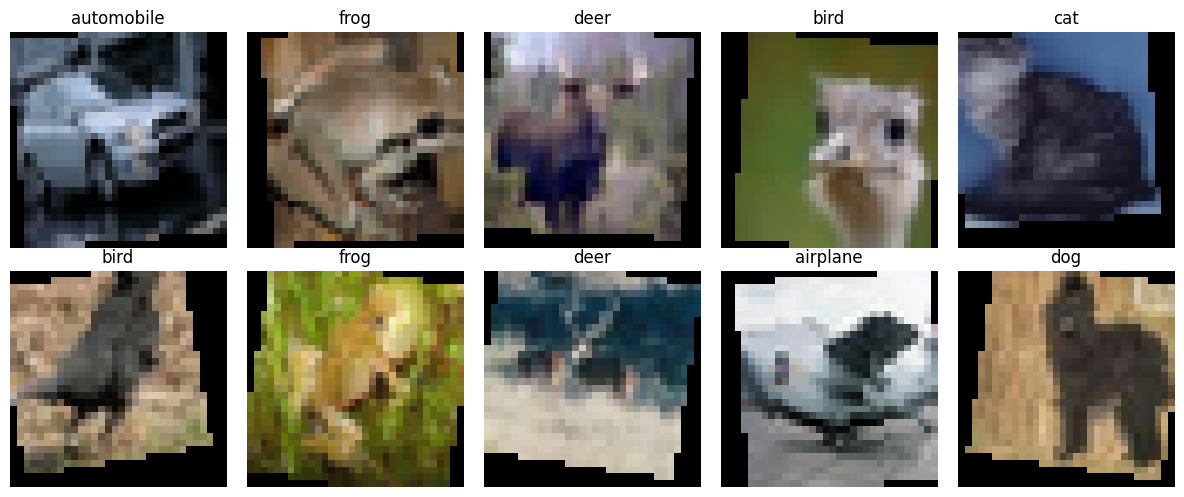

In [9]:
# Visualize some training samples
import matplotlib.pyplot as plt
import numpy as np

# Get 10 random samples
indices = np.random.choice(len(train_data), 10, replace=False)
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for idx, ax in zip(indices, axes.flat):
    img, label = train_data[idx]
    # Convert from [-0.5, 0.5] to [0, 1] for display
    img = img + 0.5
    # Permute from (C, H, W) to (H, W, C)
    img = img.permute(1, 2, 0).numpy()
    
    ax.imshow(img)
    ax.set_title(train_data.classes[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

---
# Part 3: Training and Hyperparameter Tuning (20 points)

## Scoring Rubric

Your grade for this section depends on the best test accuracy you achieve:

| Test Accuracy | Points |
|--------------|--------|
| ≥ 80% | 20 |
| 75-80% | 15 |
| 70-75% | 10 |
| < 70% | 5 |

After training, the script will find the maximum test accuracy among all experiments. The script will also save the maximum test accuracy across all epochs. 

In [10]:
"""
Setup Results Directory
"""
# Choose the folder to save model checkpoints and results
# In Colab, use a folder in your drive (/content/drive/MyDrive/...)
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

print(f"Results will be saved to: {results_dir}")
print(f"Current experiments: {len(os.listdir(results_dir))}")

Results will be saved to: results
Current experiments: 0


## Running Experiments

The cell below runs one training experiment. You can:
- Run it multiple times with different configurations
- Each run creates a new numbered folder in results_dir

Note: training can take some time, so it is advised to start early!

### What Gets Saved:
- Model checkpoints (updated `save_freq` epochs)
- Train/test losses and accuracies for each epoch (`results.pkl`)

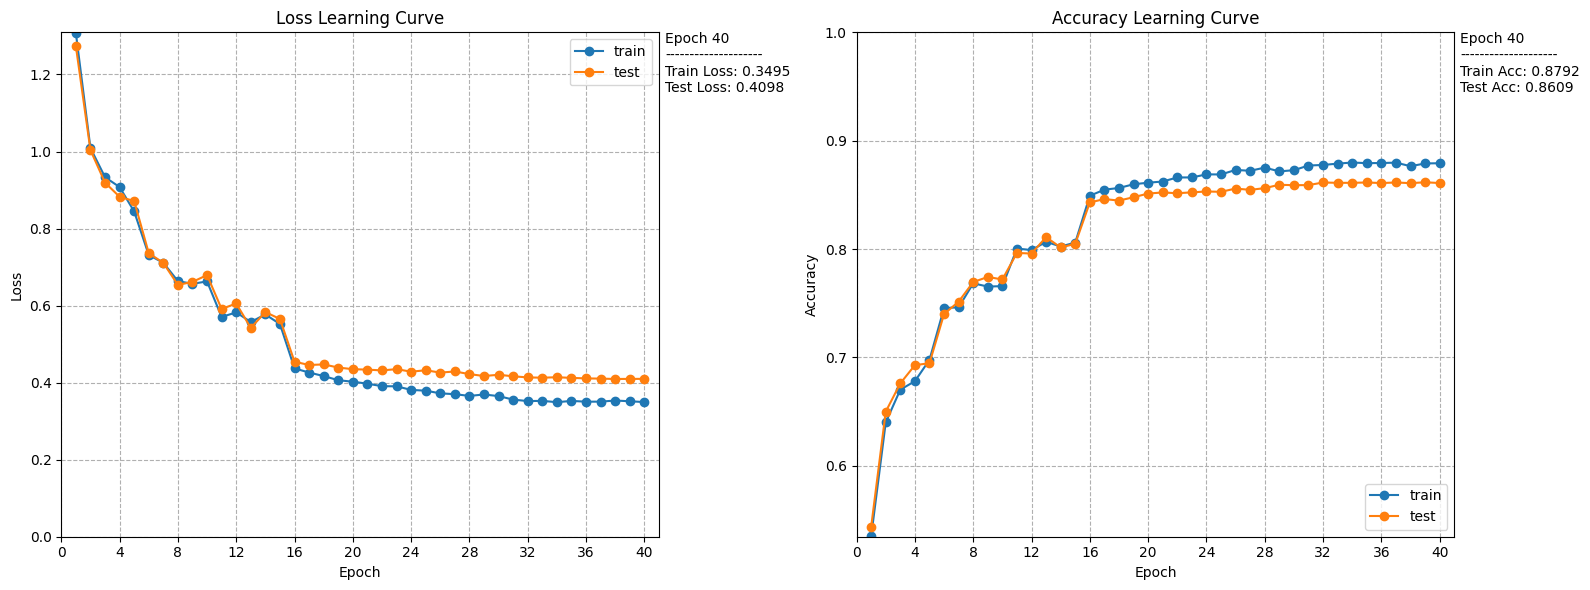

epochs: 100%|████████████████████████████████████████████████████████████████████| 40/40 [1:11:54<00:00, 107.87s/epoch]



Experiment 00 completed!
Results saved to: results/00



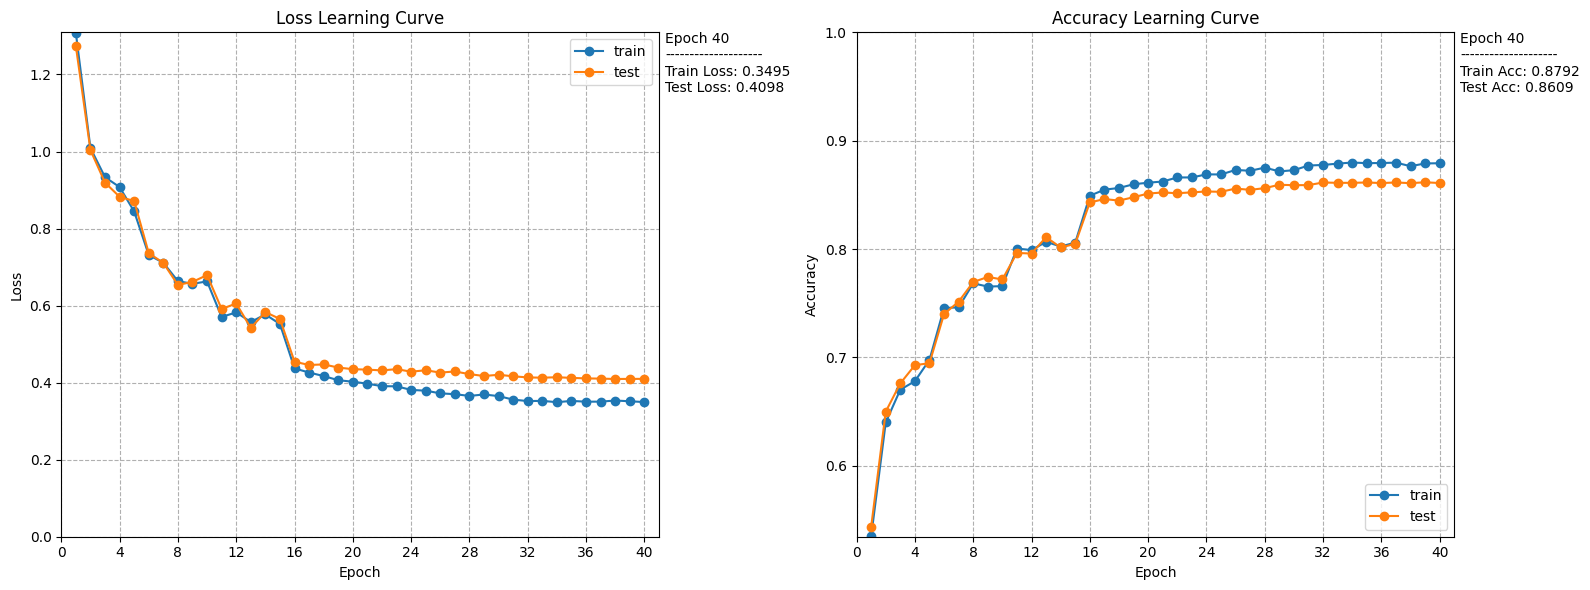

In [11]:
"""
Configure and Run Training Experiment

Modify the configurations below and run this cell to start training.
You can run this cell multiple times to try different hyperparameters.
"""

# ==================== MODEL CONFIGURATION ====================
model_config = dict(
    base_channels = 32,  # Example: 32, 64
    expands = [1,2,4],      # Example: [1, 2, 2], [2, 2, 2]
    activation = 'relu',      # Example: 'relu', 'leaky_relu'
    batchnorm = True,       # Example: True, False
    residual = True,        # Example: True, False
    )

# ==================== TRAINING CONFIGURATION ====================
train_config = dict(
    # Optimizer settings
    optim_name = 'Adam',           # Example: 'Adam', 'SGD', 'AdamW'
    optim_config = {
        'lr': 1e-3,                # Standard starting learning rate for Adam
        'weight_decay': 1e-4       # L2 regularization to prevent overfitting
    },         # Example: {'lr': 0.001, 'weight_decay': 1e-4}
    
    # Learning rate scheduler
    lr_scheduler_name = 'StepLR',    # Example: 'StepLR', 'CosineAnnealingLR'
    lr_scheduler_config = {
        'step_size': 15,           # Decay every 15 epochs
        'gamma': 0.1               # Multiply LR by 0.1
    },  # Example: {'step_size': 30, 'gamma': 0.1}
    
    # Training parameters
    n_epochs = 40,             # Example: 50, 100, 200
    batch_size = 128,           # Example: 64, 128, 256
    )

# ==================== CREATE EXPERIMENT ====================
n_experiments = len(os.listdir(results_dir))
name = f'{n_experiments:02d}'
save_path = f'{results_dir}/{name}'
os.makedirs(save_path, exist_ok=False)  # Will raise error if folder exists

print(f"\n{'='*60}")
print(f"Starting Experiment {name}")
print(f"{'='*60}")
print(f"Save path: {save_path}")

# ==================== START TRAINING ====================
print("\nInitializing model...")
model = Model(**model_config).to(Device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

print("\nStarting training...")
train(
    save_path = save_path,
    model = model,
    train_data = train_data,
    test_data = test_data,
    loss_fn = nn.CrossEntropyLoss(),
    device = Device,
    train_pbar = True,  # Set to True for progress bars during training
    val_pbar = True,    # Set to True for progress bars during validation
    plot_freq = 1,       # Plot curves every N epochs
    save_freq = 1,       # Save checkpoint every N epochs
    **train_config,
    )

print(f"\n{'='*60}")
print(f"Experiment {name} completed!")
print(f"Results saved to: {save_path}")
print(f"{'='*60}\n")

#### View Experiment Results

After running experiments, check the results table:

In [ ]:
files_to_print = []
best_acc = 0
best_file = ""
for d in os.listdir(results_dir):
    exp_path = f'{results_dir}/{d}'
    for f in os.listdir(exp_path):
        if f.endswith('.pkl'):
            with open(f'{exp_path}/{f}', 'rb') as file:
                loss = pickle.load(file)
            final_test_acc = max(loss['test_accs']) * 100
            print(f'Experiment {d}, File: {exp_path}/{f}, Max Test Accuracy: {final_test_acc:.2f}%')

            if final_test_acc > best_acc:
                best_acc = final_test_acc
                best_file = f'{exp_path}/{f}'

print(f'\nBest Test Accuracy across all experiments: {best_acc:.2f}% at {best_file}')

Experiment 00, File: results/00/results.pkl, Max Test Accuracy: 86.16%

Best Test Accuracy across all experiments: 86.16% at results/00/results.pkl


---
# Part 4: Submission

## Creating Submission Zip

Run the cell below to create your submission file. It will:
1. Identify your best performing model
2. Copy the best configurations to the working directory
3. Copy the results table
4. Create a zip file with all required files

### Submission Checklist 
Your zip file should contain:
- `HW4.ipynb` - Your completed notebook
- `results.pkl` - Results file with best run

In [ ]:
"""
Create Submission Zip File
"""

print("Preparing submission...\n")

# Load results table
try:
    # Copy best model configs to working directory
    print("Copying configuration files...")
    os.system(f'cp {best_file} .')
    print(f"{best_file}")

    # Create zip file
    print("\nCreating submission zip...")
    files_to_zip = [
        'HW4.ipynb',
        'results.pkl'
    ]

    zip_files('HW4_submission.zip', *files_to_zip)
    print("\nSubmission zip created successfully!")
    print("\nFile: HW4_submission.zip")
    print("\n" + "="*60)
    print("Ready to submit!")
    print("="*60)
    print(f"\nYour best model achieved {best_acc}% test accuracy")

except FileNotFoundError:
    print("Error: No experiments found!")
    print("Please run at least one training experiment before creating submission.")
except Exception as e:
    print(f"Error creating submission: {str(e)}")
